In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Create data: two moons + noise
X, y = make_moons(n_samples=400, noise=0.08, random_state=42)
X = StandardScaler().fit_transform(X)


In [2]:
db = DBSCAN(eps=0.25, min_samples=5).fit(X)
labels = db.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Detected Clusters: {n_clusters}")


Detected Clusters: 2


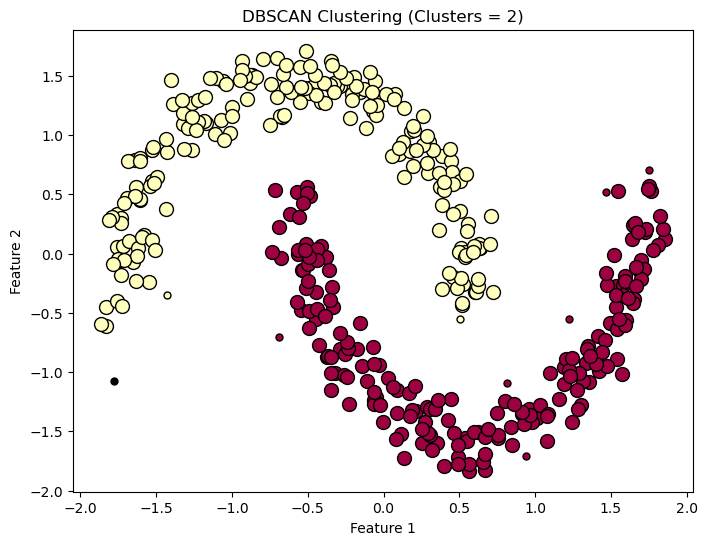

In [3]:
"""
Purpose: Visualize clusters of varying shapes and outliers.
Why use it: To understand density-based clustering vs centroid-based.
When to use it: In exploratory data analysis or anomaly detection.

Interpretation:
Each color = a cluster.
Black points = noise (unclustered anomalies).
Irregular shapes = DBSCAN’s ability to adapt to nonlinear manifolds.
"""
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(8,6))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # black for noise
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
plt.title(f"DBSCAN Clustering (Clusters = {n_clusters})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


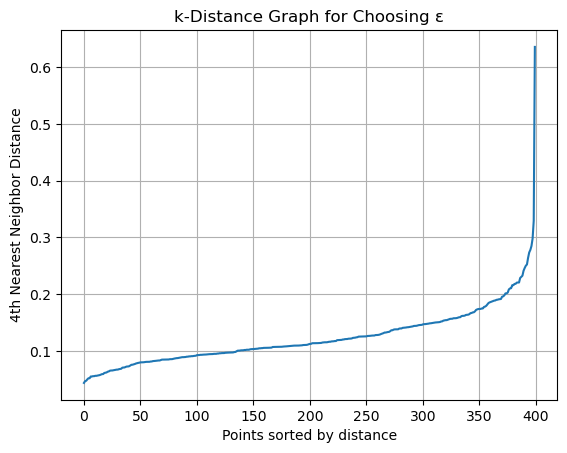

In [4]:
"""
Purpose: Estimate the ideal ε.
Why use it: DBSCAN performance depends heavily on ε.
When to use it: Before training, to find the “elbow” in distance distribution.

Intuition:
The “elbow” (where the slope sharply changes) marks a natural threshold —
points beyond this distance start being isolated (potential noise).
"""
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("k-Distance Graph for Choosing ε")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


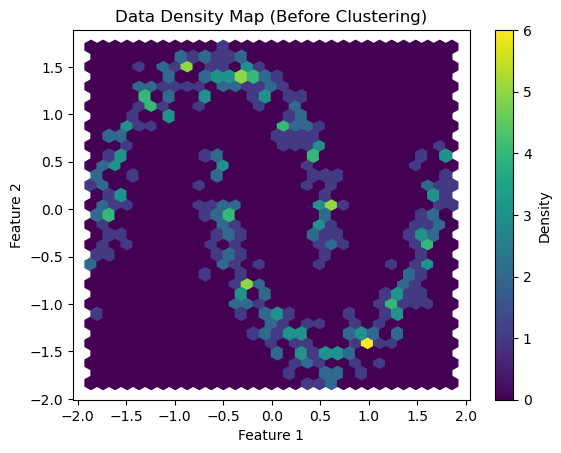

In [5]:
"""
Purpose: Visualize underlying point density.
Why use it: To confirm whether DBSCAN will find clusters.
When to use it: Before running DBSCAN to gauge separability.

Intuition:
High-density hexagonal regions correspond to likely cluster cores.
"""
plt.hexbin(X[:, 0], X[:, 1], gridsize=30, cmap='viridis')
plt.colorbar(label='Density')
plt.title("Data Density Map (Before Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


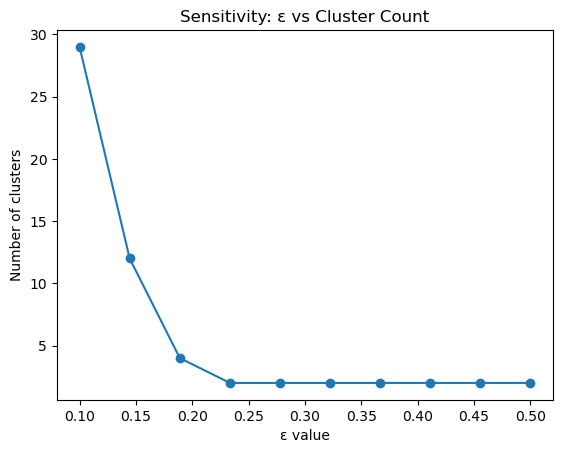

In [6]:
"""
Purpose: Show how ε affects model complexity.
Intuition:
Too small → fragmented clusters, many outliers.
Too large → merged clusters, less structure.
"""
eps_values = np.linspace(0.1, 0.5, 10)
cluster_counts = []
for e in eps_values:
    labels = DBSCAN(eps=e, min_samples=5).fit(X).labels_
    cluster_counts.append(len(set(labels)) - (1 if -1 in labels else 0))
plt.plot(eps_values, cluster_counts, marker='o')
plt.xlabel("ε value")
plt.ylabel("Number of clusters")
plt.title("Sensitivity: ε vs Cluster Count")
plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


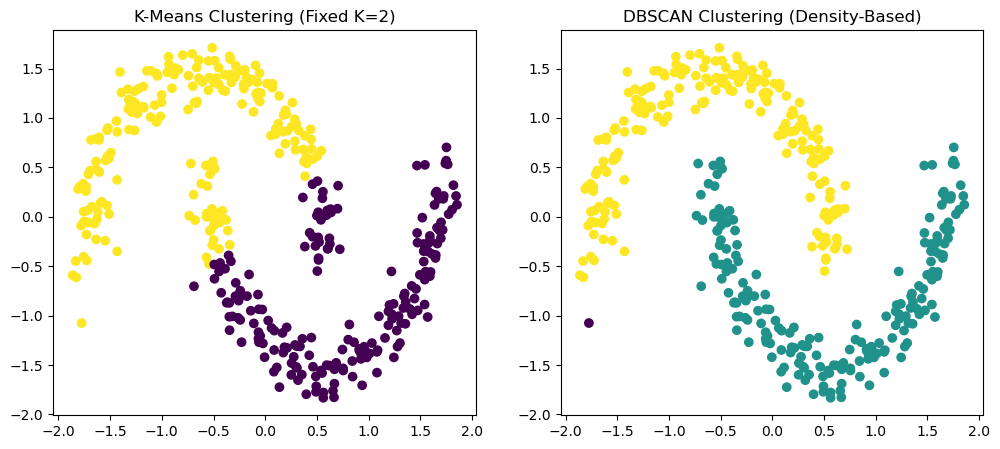

In [7]:
"""
Purpose: Compare assumption-based (K-Means) vs assumption-free (DBSCAN) clustering.
Insight:
K-Means imposes circular clusters, DBSCAN adapts to real shapes.
Outliers visible in DBSCAN (black points) are forced into clusters by K-Means.
"""
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42).fit(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='viridis')
axes[0].set_title("K-Means Clustering (Fixed K=2)")

axes[1].scatter(X[:,0], X[:,1], c=db.labels_, cmap='viridis')
axes[1].set_title("DBSCAN Clustering (Density-Based)")
plt.show()


In [9]:
"""
Purpose: Quantify how DBSCAN segmented the data.
Why use it: Evaluate cluster balance and proportion of noise points.
"""

import pandas as pd
unique, counts = np.unique(labels, return_counts=True)
summary = pd.DataFrame({"Cluster": unique, "Points": counts})
summary["Type"] = ["Noise" if c == -1 else "Cluster" for c in summary["Cluster"]]
summary


,Cluster,Points,Type
0,0,200,Cluster
1,1,200,Cluster
